# **Recommendation System Project: [(Indonesia Tourism Destination)](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination)**
- **Nama:** Indira Aline
- **Email:** indiradira63@gmail.com
- **ID Dicoding:** indira_kbs

# **Import Semua Packages/Library yang Digunakan**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os

from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from pathlib import Path

# Mount Google Drive (Colab)
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Loading**

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yongpon","key":"1dd3283e358f8b2e41141009ae9eed48"}'}

In [ ]:
# Setup Kaggle API authentication
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls -l /root/.kaggle/

total 4
-rw------- 1 root root 63 May 25 07:27 kaggle.json


In [ ]:
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 324MB/s]


In [ ]:
import zipfile,os,shutil

In [ ]:
fileZip = "indonesia-tourism-destination.zip"
extracZip = zipfile.ZipFile(fileZip, 'r')
extracZip.extractall("dataset")

In [ ]:
os.listdir("/content/dataset")

['package_tourism.csv',
 'tourism_rating.csv',
 'user.csv',
 'tourism_with_id.csv']

Dataset yang digunakan yaitu [Indonesia Tourism Destination](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination) dengan `tourism_with_id.csv` dan `tourism_rating.csv` sebagai dataset.

# **Data Understanding**

Menampilkan dataset yaitu `tourism_with_id.csv` dan `tourism_rating.csv` menggunakan library pandas dengan format .csv menjadi dataframe.

In [ ]:
places = pd.read_csv('dataset/tourism_with_id.csv')
ratings = pd.read_csv('dataset/tourism_rating.csv')

print('Jumlah places: ', len(places.Place_Id.unique()))
print('Jumlah ratings: ', len(ratings.Place_Ratings))

Jumlah places:  437
Jumlah ratings:  10000


## Exploratory Data Analysis

### Univariate

Tahap ini akan dilakukan proses investigasi pertama pada data untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data.

2.1. _Tourism Destinations Dataset (Places)_

Meninjau informasi variabel dari _places dataset_ berupa jumlah kolom, nama kolom, jumlah data per kolom dan tipe data.

In [ ]:
places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [ ]:
places.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [ ]:
places.describe()

,Place_Id,Price,Rating,Time_Minutes,Lat,Long,Unnamed: 11,Unnamed: 12
count,437.000000,437.000000,437.000000,205.000000,437.000000,437.000000,0.0,437.000000
mean,219.000000,24652.173913,4.442792,82.609756,-7.095438,109.160142,NaN,219.000000
std,126.295289,66446.374709,0.208587,52.872339,0.727241,1.962848,NaN,126.295289
min,1.000000,0.000000,3.400000,10.000000,-8.197894,103.931398,NaN,1.000000
25%,110.000000,0.000000,4.300000,45.000000,-7.749590,107.578369,NaN,110.000000
50%,219.000000,5000.000000,4.500000,60.000000,-7.020524,110.237468,NaN,219.000000
75%,328.000000,20000.000000,4.600000,120.000000,-6.829411,110.431869,NaN,328.000000
max,437.000000,900000.000000,5.000000,360.000000,1.078880,112.821662,NaN,437.000000


2.2. _Ratings Dataset_

Memeriksa informasi variabel dari _ratings dataset_ berupa jumlah kolom, nama kolom, jumlah data per kolom dan tipe data.

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [ ]:
ratings.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [ ]:
ratings.describe()

,User_Id,Place_Id,Place_Ratings
count,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,3.066500
std,86.137374,126.228335,1.379952
min,1.000000,1.000000,1.000000
25%,77.000000,108.750000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


# **Data Preparation**

Di sini, data preparation merupakan proses transformasi data menjadi bentuk yang dapat diterima oleh model machine learning nantinya. Proses data preparation yang akan dilakukan, yaitu membersihkan data _missing value_, dan melakukan peninjauan data duplikat.

Menghapus Kolom yang Tidak Diperlukan

Data yang diperlukan hanya pada kolom `Place_Id`, `Place_Name`, dan `Category`, sisanya akan dihapus.

In [ ]:
places = places.drop(['Description', 'City', 'Price', 'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12'], axis=1)

Pengecekan Missing Value

In [ ]:
places.isnull().sum()

,0
Place_Id,0
Place_Name,0
Category,0


In [ ]:
ratings.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0


Pengecekan Data Duplikat

In [ ]:
print(f'Jumlah data places yang duplikat: {places.duplicated().sum()}')
print(f'Jumlah data rating yang duplikat: {ratings.duplicated().sum()}')

Jumlah data places yang duplikat: 0
Jumlah data rating yang duplikat: 79


Melakukan penghapusan duplikat

In [ ]:
ratings.drop_duplicates(inplace = True)

# **Modelling**

Proses pemodelan sistem rekomendasi ini dirancang untuk menghasilkan model yang dapat memberikan saran destinasi wisata terbaik sesuai dengan preferensi pengguna, dengan memanfaatkan teknik _content-based filtering_ dan _collaborative filtering_ berdasarkan penilaian yang diberikan

## _Content-based_

Teknik ini berfungsi menyarankan item mirip dengan riwayat preferensi pengguna. Prosesnya melibatkan pembuatan profil minat berdasarkan penilaian pengguna terhadap konten tertentu. Dengan memprioritaskan kemiripan fitur item, sistem berusaha menyajikan rekomendasi yang sesuai. Akurasinya bergantung pada kuantitas dan kualitas data yang diinput pengguna.

_TF-IDF Vectorizer_ berperan dalam menentukan atribut-atribut signifikan setiap klasifikasi tempat wisata. Menggunakan _library scikit-learn_, nilai-nilai tersebut diubah menjadi bentuk vektor melalui operasi _fit_transform_ dan _transform_, disertai proses pembagian data yang terintegrasi.

In [ ]:
tf = TfidfVectorizer()

tf.fit(places['Category'])

tf.get_feature_names_out()

array(['alam', 'bahari', 'budaya', 'cagar', 'hiburan', 'ibadah',
       'perbelanjaan', 'pusat', 'taman', 'tempat'], dtype=object)

In [ ]:
tfidf_matrix = tf.fit_transform(places['Category'])
tfidf_matrix.shape

(437, 10)

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.70710678]])

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=places.Place_Name
).sample(10, axis=0)

,alam,bahari,budaya,cagar,hiburan,ibadah,perbelanjaan,pusat,taman,tempat
Place_Name,,,,,,,,,,
Studio Alam Gamplong,0.000000,0.0,0.0,0.000000,0.707107,0.0,0.000000,0.000000,0.707107,0.0
Pantai Glagah,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
Pasar Petak Sembilan,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.707107,0.707107,0.000000,0.0
Water Blaster Bukit Candi Golf,0.000000,0.0,0.0,0.000000,0.707107,0.0,0.000000,0.000000,0.707107,0.0
Hutan Bambu Keputih,0.707107,0.0,0.0,0.707107,0.000000,0.0,0.000000,0.000000,0.000000,0.0
Gunung Papandayan,0.707107,0.0,0.0,0.707107,0.000000,0.0,0.000000,0.000000,0.000000,0.0
Umbul Sidomukti,0.707107,0.0,0.0,0.707107,0.000000,0.0,0.000000,0.000000,0.000000,0.0
Pantai Greweng,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
Taman Hutan Tebet,0.000000,0.0,0.0,0.000000,0.707107,0.0,0.000000,0.000000,0.707107,0.0


### _Cosine Similarity_

Melakukan perhitungan derajat kesamaan atau _similatiry degree_ antar nama tempat wisata dengan teknik _cosine similarity_ menggunakan _library scikit-learn_.

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
cosine_sim_df = pd.DataFrame(
    cosine_sim, index=places.Place_Name, columns=places.Place_Name)
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=0)

Shape: (437, 437)


Place_Name,Monumen Nasional,Kota Tua,Dunia Fantasi,Taman Mini Indonesia Indah (TMII),Atlantis Water Adventure,Taman Impian Jaya Ancol,Kebun Binatang Ragunan,Ocean Ecopark,Pelabuhan Marina,Pulau Tidung,...,Monumen Bambu Runcing Surabaya,House of Sampoerna,Atlantis Land Surabaya,Taman Hiburan Rakyat,Taman Mundu,Museum Mpu Tantular,Taman Bungkul,Taman Air Mancur Menari Kenjeran,Taman Flora Bratang Surabaya,Gereja Perawan Maria Tak Berdosa Surabaya
Place_Name,,,,,,,,,,,,,,,,,,,,,
Heha Sky View,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
Ekowisata Mangrove Wonorejo,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Happyfarm Ciwidey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pantai Siung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pulau Pramuka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Museum Nike Ardilla,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Gereja Tiberias Indonesia Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Taman Buah Surabaya,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
Hutan Bambu Keputih,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### _Recommendation Testing_

Mengimplementasikan fungsi _place_recommendations_ guna menghasilkan rekomendasi tempat wisata berdasarkan tingkat kesamaan kategorinya.

In [ ]:
def place_recommendations(place_name, similarity_data=cosine_sim_df, items=places[['Place_Name', 'Category']], k=5):
    index = similarity_data.loc[:,place_name].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(place_name, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
place_name = 'Monumen Nasional'
places[places.Place_Name.eq(place_name)]

,Place_Id,Place_Name,Category
0,1,Monumen Nasional,Budaya


In [ ]:
place_recommendations(place_name)

,Place_Name,Category
0,Candi Sewu,Budaya
1,Museum Benteng Vredeburg Yogyakarta,Budaya
2,Museum Satria Mandala,Budaya
3,Kyotoku Floating Market,Budaya
4,Bandros City Tour,Budaya


Output yang dihasilkan membuktikan efektivitas sistem dalam memberikan rekomendasi berdasarkan kesamaan kategori, seperti tampak pada contoh 'Monumen Nasional' yang merekomendasikan tempat-tempat budaya lainnya.

## _Collaborative Filtering_

Proses _encoding_ fitur `User_Id` pada dataset _ratings_ menjadi _array_.



In [ ]:
user_ids = ratings['User_Id'].unique().tolist()
print('list User_Id: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded User_Id : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke User_Id: ', user_encoded_to_user)

list User_Id:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

Proses _encoding_ fitur `Place_Id` pada dataset _ratings_ menjadi _array_.

In [ ]:
place_ids = ratings['Place_Id'].unique().tolist()
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

Meninjau jumlah user, jumlah tempat, penilaian minimal, dan penilaian maksimal.

In [ ]:
users_count = len(user_to_user_encoded)
place_count = len(place_encoded_to_place)

ratings['rating'] = ratings['Place_Ratings'].values.astype(np.float32)

min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

print(f'Users Count: {users_count}')
print(f'Places Count: {place_count}')
print(f'Min rating: {min_rating}')
print(f'Max rating: {max_rating}')

Users Count: 300
Places Count: 437
Min rating: 1.0
Max rating: 5.0


## Split Data Latih dan Data Validasi

Acak _ratings dataset_

In [ ]:
ratings = ratings.sample(frac=1, random_state=42)
ratings

,User_Id,Place_Id,Place_Ratings,rating
5315,161,260,2,2.0
518,17,262,2,2.0
4362,133,191,5,5.0
8447,255,156,1,1.0
9105,274,78,3,3.0
...,...,...,...,...
5782,174,296,3,3.0
5237,159,69,4,4.0
5437,164,24,5,5.0
871,28,131,5,5.0


Membagi _dataset_ menjadi data latih (_train_) dan data uji (_test_), yaitu sebesar 20% data uji dan 80% data latih.

In [ ]:
x = ratings[['User_Id', 'Place_Id']].values
y = ratings['rating'].apply(lambda x: (
    x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[161 260]
 [ 17 262]
 [133 191]
 ...
 [164  24]
 [ 28 131]
 [221 118]] [0.25 0.25 1.   ... 1.   1.   0.5 ]


## Model Development

_Layer embedding_ bertugas mengkonversi data numerik input menjadi bentuk vektor yang lebih kaya makna dan mudah diproses oleh algoritma _machine learning_.

In [ ]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, users_count, place_count, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.users_count = users_count
    self.place_count = place_count
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        users_count,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-8)
    )
    self.user_bias = layers.Embedding(users_count, 1)
    self.place_embedding = layers.Embedding(
        place_count,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-8)
    )
    self.place_bias = layers.Embedding(place_count, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    place_vector = self.place_embedding(inputs[:, 1])
    place_bias = self.place_bias(inputs[:, 1])

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x)

In [ ]:
model = RecommenderNet(users_count, place_count, 50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Menambahkan _callback EarlyStopping_ yang akan menghentikan _training_ jika tidak ada peningkatan selama 5 _epochs_.

In [ ]:
callbacks = EarlyStopping(
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True,
)

Latih model

Apply encoding to both training and validation data and latih model using the encoded dat

In [ ]:
x_train_encoded = np.array([[user_to_user_encoded[user_id], place_to_place_encoded[place_id]]
                            for user_id, place_id in x_train])

x_val_encoded = np.array([[user_to_user_encoded[user_id], place_to_place_encoded[place_id]]
                          for user_id, place_id in x_val])

history = model.fit(
    x=x_train_encoded,
    y=y_train,
    batch_size=8,
    epochs=100,
    validation_data=(x_val_encoded, y_val),
    callbacks=[callbacks]
)

Epoch 1/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6952 - root_mean_squared_error: 0.3445 - val_loss: 0.6935 - val_root_mean_squared_error: 0.3496
Epoch 2/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6926 - root_mean_squared_error: 0.3406 - val_loss: 0.6934 - val_root_mean_squared_error: 0.3495
Epoch 3/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6914 - root_mean_squared_error: 0.3413 - val_loss: 0.6934 - val_root_mean_squared_error: 0.3495
Epoch 4/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6914 - root_mean_squared_error: 0.3409 - val_loss: 0.6933 - val_root_mean_squared_error: 0.3494
Epoch 5/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6896 - root_mean_squared_error: 0.3463 - val_loss: 0.6932 - val_root_mean_squared_error: 0.3494
Epoch 6/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6887 - root_mean_squared_error: 0.3415 - val_loss: 0.6932 - val_root_mean_squared_error: 0.3494
Epoch 7/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2m

Visualisasi grafik data _training_ dan _testing_ untuk masing-masing metrik _Root Mean Square Error_ dan _loss function_.

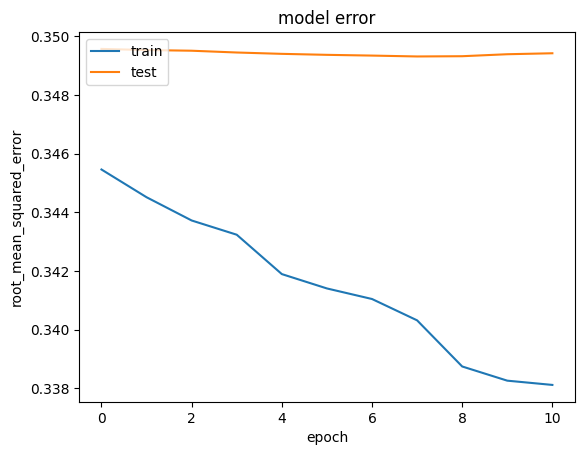

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

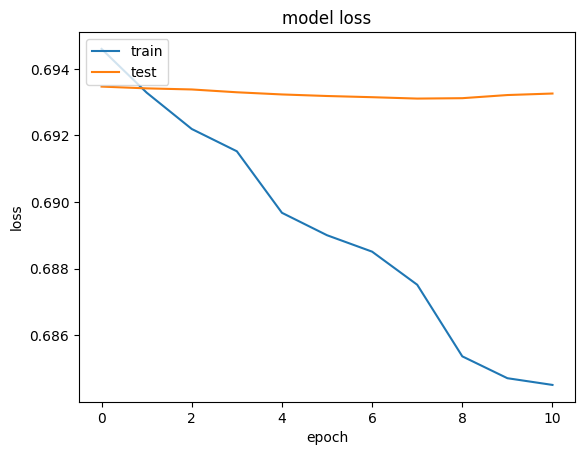

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Uji Rekomendasi

Melakukan percobaan terhadap rekomendasi yang diberikan, termasuk kasus di mana pengguna belum memberikan penilaian pada tempat tertentu (`place_not_rated`).

In [ ]:
place_df = places
ratings_df = ratings

In [ ]:
user_id = ratings_df.User_Id.sample(1).iloc[0]
place_rated = ratings_df[ratings_df.User_Id == user_id]

place_not_rated = place_df[~place_df['Place_Id'].isin(
    place_rated.Place_Id.values)]['Place_Id']
place_not_rated = list(
    set(place_not_rated).intersection(set(place_to_place_encoded.keys()))
)

place_not_rated = [
    [place_to_place_encoded.get(x)] for x in place_not_rated]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_rated), place_not_rated)
)

Melakukan pengujian prediksi hasil rekomendasi tempat berdasarkan nama tempat dan kategori.

In [ ]:
ratings = model.predict(user_place_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_rated[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('=====' * 8)
print('Place with high ratings from user')
print('-----' * 8)

top_place_user = (
    place_rated.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

place_df_rows = place_df[place_df['Place_Id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.Place_Name + ':', row.Category)

print('-----' * 8)
print('Top 10 place recommendation')
print('-----' * 8)

recommended_place = place_df[place_df['Place_Id'].isin(recommended_place_ids)]
for row in recommended_place.itertuples():
    print(row.Place_Name + ':', row.Category)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Showing recommendations for users: 32
Place with high ratings from user
----------------------------------------
Curug Cilengkrang: Cagar Alam
Gunung Lalakon: Cagar Alam
Taman Hutan Raya Ir. H. Juanda: Cagar Alam
Grand Maerakaca: Taman Hiburan
Food Junction Grand Pakuwon: Pusat Perbelanjaan
----------------------------------------
Top 10 place recommendation
----------------------------------------
Taman Vanda: Taman Hiburan
Taman Sejarah Bandung: Budaya
Puspa Iptek Sundial: Taman Hiburan
Museum Pendidikan Nasional: Budaya
Water Park Bandung Indah: Taman Hiburan
Curug Anom: Cagar Alam
Taman Film: Budaya
Museum Nike Ardilla: Budaya
Sanghyang Heuleut: Cagar Alam
Masjid Al-Imtizaj: Tempat Ibadah


Implementasi sistem yang diamati melibatkan seleksi random terhadap pengguna, kemudian menampilkan rekomendasi berupa lokasi-lokasi dengan nilai rating tertinggi dari user tersebut.

*   Curug Cilengkrang: Cagar Alam
*   Gunung Lalakon: Cagar Alam
*   Taman Hutan Raya Ir. H. Juanda: Cagar Alam
*   Grand Maerakaca: Taman Hiburan
*   Food Junction Grand Pakuwon: Pusat Perbelanjaan

Proses berikutnya menampilkan daftar 10 tempat rekomendasi yang disesuaikan dengan kategori dari pengguna acak tersebut. Nampak bahwa sistem memberikan beberapa rekomendasi dengan kategori identik, seperti:

*   Taman Vanda: Taman Hiburan
*   Taman Sejarah Bandung: Budaya
*   Puspa Iptek Sundial: Taman Hiburan
*   Museum Pendidikan Nasional: Budaya
*   Water Park Bandung Indah: Taman Hiburan
*   Curug Anom: Cagar Alam
*   Taman Film: Budaya
*   Museum Nike Ardilla: Budaya
*   Sanghyang Heuleut: Cagar Alam
*   Masjid Al-Imtizaj: Tempat Ibadah

# **Kesimpulan**

Dengan demikian, terbukti bahwa sistem mampu memberikan rekomendasi efektif melalui kedua pendekatan. _Collaborative Filtering_ memerlukan data rating pengguna, sementara _content-based filtering_ bekerja tanpa data penilaian karena menggunakan karakteristik tempat (kategori) sebagai dasar rekomendasi.